<a href="https://colab.research.google.com/github/michelucci/O2T-Real-Data-Paper/blob/master/notebooks/O2_prediction_model_Network_C_O2T_Paper_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper figures preparation

Author: Umberto Michelucci

**Version 1.0**

We first import the libraries we need. Many are non necessary but are useful to write shorter code. For example one you have imported `keras` you don't need to `from tensorflow.keras.models import Sequential` but this makes some of the code shorter. In fact instead of writing `keras.models.Sequential()` you can simply use `Sequential()`.

In [1]:
# Basics
import numpy as np
import pandas as pd

# for timing measurements
import time

# Only in Google Colab
#%tensorflow_version 2.x

import tensorflow as tf

# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras.backend as K

# Various
from numpy import random
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns



print(tf.__version__)

2.1.0-rc1


# Load the $\theta/90$ dataset

## Read the files (Local files)

In [153]:
train_data_df = pd.read_csv('../data/train_data1.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets1.csv', names=['T', 'O2'], header = None)

train_data_df2 = pd.read_csv('../data/train_data2.csv', header = None)
train_target_df2 = pd.read_csv('../data/train_targets2.csv', names=['T', 'O2'], header = None)

In [154]:
print(train_data_df.shape)
print(train_data_df2.shape)

(3780, 50)
(3780, 50)


In [155]:
train_target_df.head()

,T,O2
0,20.0,35.0
1,20.0,35.0
2,20.0,35.0
3,20.0,35.0
4,20.0,35.0


Note that `T` is measured in degree centigrade ($^\circ \ C$), and the oxygen concentration $[O_2]$ in % Air. We normlize to have a maximum of one. This would not be strictly necessary.

In [156]:
train_target_df[['O2']] = train_target_df[['O2']]/100.0
train_target_df[['T']] = train_target_df[['T']]/45.0

train_target_df2[['O2']] = train_target_df2[['O2']]/100.0
train_target_df2[['T']] = train_target_df2[['T']]/45.0

Note that the values for $T$ are going from 0 to 1. To obtin the actual temperature in Celsius degrees, you need to multiply by $45$.

In [157]:
print(train_target_df['T'].unique())
print(train_target_df['T'].unique()*45)

[0.44444444 0.55555556 0.22222222 0.66666667 0.77777778 0.33333333
 0.88888889 1.         0.11111111]
[20. 25. 10. 30. 35. 15. 40. 45.  5.]


In [158]:
train_data_df2.drop(train_data_df2[train_target_df2['O2'] == 0].index, inplace=True)
train_target_df2.drop(train_target_df2[train_target_df['O2'] == 0].index, inplace=True)
train_data_df2 = train_data_df2.reset_index(drop = True);
train_target_df2 = train_target_df2.reset_index(drop = True);
print(train_data_df2.shape)

(3600, 50)


In [159]:
print(train_target_df[train_target_df['T'] == 5./45.].shape)
print(train_target_df2[train_target_df2['T'] == 5./45.].shape)

(420, 2)
(400, 2)


To check how many values we have for each temperature we can do easily with ```groupby()```.

In [160]:
train_target_df.groupby('T').count()

,O2
T,
0.111111,420
0.222222,420
0.333333,420
0.444444,420
0.555556,420
0.666667,420
0.777778,420
0.888889,420
1.000000,420


Each of the temperature has 420 observations.

In [161]:
train_target_df.groupby('T').nunique()

,T,O2
T,,
0.111111,1,21
0.222222,1,21
0.333333,1,21
0.444444,1,21
0.555556,1,21
0.666667,1,21
0.777778,1,21
0.888889,1,21
1.000000,1,21


And each temperature has 21 unique values of oxygen concentration.

In [162]:
np.sort(train_target_df[train_target_df['T'] == 5./45.]['O2'].unique())*100

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

## Reset the index

In [163]:
train_data_df = train_data_df.reset_index(drop = True);
train_target_df = train_target_df.reset_index(drop = True);

train_data_df2 = train_data_df2.reset_index(drop = True);
train_target_df2 = train_target_df2.reset_index(drop = True);

The unique values of the temperature ($T$) are, as expected

In [164]:
np.unique(train_target_df['T'])*45

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45.])

In [165]:
print(train_data_df.shape)
print(train_data_df2.shape)

(3780, 50)
(3600, 50)


# Frequency values

In [166]:
wred = [  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.]

# Dataset split

In [167]:
np.random.seed(42)
rnd = np.random.rand(len(train_target_df)) < 0.8
rnd2 = np.random.rand(len(train_target_df2)) < 0.8

Note that the values of $\theta$ are negative in the original dataset, and therefore we convert it to positive. This was a test to see if learning was more efficient. A complete comparison has not have been done and is not clear if this really brings benefits. At the moment the working hypothesis is that positive values works better.

In [168]:
data_train = -train_data_df[rnd]
data_dev = -train_data_df[~rnd]
targets_train = train_target_df[rnd]
targets_dev = train_target_df[~rnd]

data_train2 = train_data_df2[rnd2]
data_dev2 = train_data_df2[~rnd2]
targets_train2 = train_target_df2[rnd2]
targets_dev2 = train_target_df2[~rnd2]

Since the inputs are measurements of a phase divided by 90, the values will remain below 1.

In [170]:
print(np.max(np.max(data_train)))
print(np.min(np.min(data_train)))
print(np.max(np.max(data_train2)))
print(np.min(np.min(data_train2)))

0.8895333333333335
0.015
0.9771435209995538
0.3324222501292755


In [171]:
print('Number of training data observations is ', data_train.shape)
print('Number of dev      data observations is ', data_dev.shape)

Number of training data observations is  (3024, 50)
Number of dev      data observations is  (756, 50)


# Plot 1

Let's check some data observations to get an idea of how they looks like.

In [20]:
train_target_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0]

T     0.111111
O2    0.050000
Name: 1760, dtype: float64

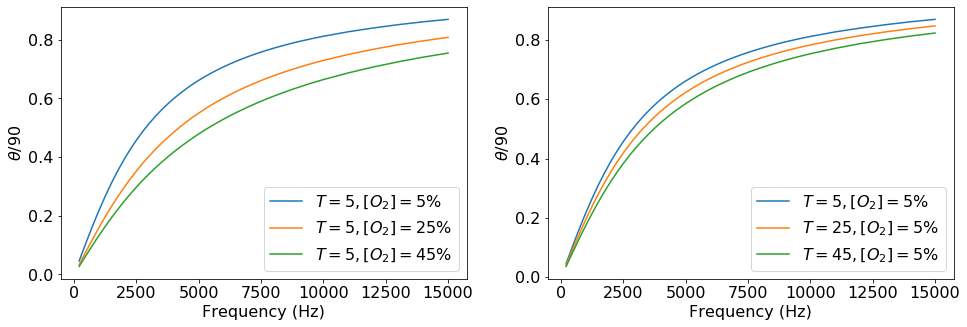

In [21]:
fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)

ax.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=5, [O_2]=5 \%$' )
ax.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 25./100.)].iloc[0], label = '$T=5, [O_2]=25 \%$' )
ax.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 45./100.)].iloc[0], label = '$T=5, [O_2]=45 \%$' )
ax.legend(fontsize = 16)
ax.tick_params(labelsize=16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / 90$', fontsize = 16)


ax2 = fig.add_subplot(1, 2, 2)


ax2.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=5, [O_2]=5 \%$' )
ax2.plot(wred, -train_data_df[(train_target_df['T'] == 25./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=25, [O_2]=5 \%$' )
ax2.plot(wred, -train_data_df[(train_target_df['T'] == 45./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=45, [O_2]=5 \%$' )
ax2.legend(fontsize = 16)
ax2.tick_params(labelsize=16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / 90$', fontsize = 16)
plt.show()

Text(0, 0.5, '$\\theta / 90$')

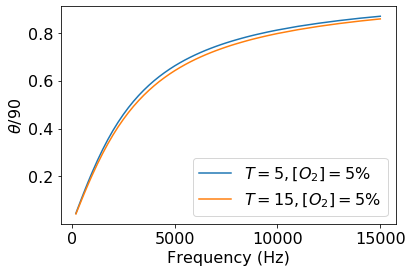

In [22]:
plt.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=5, [O_2]=5 \%$' )
plt.plot(wred, -train_data_df[(train_target_df['T'] == 15./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=15, [O_2]=5 \%$' )
#plt.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 45./100.)].iloc[0], label = '$T=5, [O_2]=45 \%$' )
plt.legend(fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / 90$', fontsize = 16)

**NOTE**: looking at how similar those two curves are, we expect that detecting the temperature will be more difficult.

## Helper Functions

In [23]:
def MAE_T_list_generator(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks

In [24]:
def MAE_O2_list_generator(step, targets_dev, preds_df):
    breaks = np.arange(step,101.0, step)
    MAE_list = []
    MAE_xticks = []
    MAE_boxplot = []
    for O2_ in breaks:
        elmts = (targets_dev['O2'] < O2_/100.0) & (targets_dev['O2'] >= (O2_-step)/100.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(100*np.abs(tmp2_['O2'].values- tmp_['O2'].values))

        #print ("MAE for range [", int(O2_), ",", int(O2_-step), "] is", mae_)

        MAE_boxplot.append(list(100.0*np.abs(tmp_['O2'].values-tmp2_['O2'].values)))

        MAE_list.append(mae_)
        MAE_xticks.append("["+ str(int(O2_-step))+ ","+ str(int(O2_))+ "]")
    
    return MAE_boxplot, MAE_list, MAE_xticks

In [25]:
# Get predictions
def _get_predictions(model, targets_dev, data_dev):
    preds = model.predict(data_dev)
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['O2', 'T']
    targets_dev_ = targets_dev.reset_index(drop = True)
    preds_df_ = preds_df.reset_index(drop = True)
    
    return targets_dev_, preds_df_

In [26]:
def get_mae(MAE_boxplot_):
    flat_list = [item for sublist in MAE_boxplot_ for item in sublist]
    return np.mean(flat_list)

# Function to get predictions

In [192]:
def get_predictions(model_):
    (O2T, O2, T) = model_.predict(data_dev)
    preds_exp_df = pd.DataFrame(O2T)
    preds_exp_df.columns = ['O2', 'T']
    preds_exp_o2_df = pd.DataFrame(O2[:,0])
    preds_exp_o2_df.columns = ['O2']

    preds_exp_T_df = pd.DataFrame(T[:,0])
    preds_exp_T_df.columns = ['T']
    
    preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
    preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)
    
    return preds_exp_o2_df, preds_exp_T_df

def get_predictions2(model_):
    (O2T, O2, T) = model_.predict(data_dev2)
    preds_exp_df = pd.DataFrame(O2T)
    preds_exp_df.columns = ['O2', 'T']
    preds_exp_o2_df = pd.DataFrame(O2[:,0])
    preds_exp_o2_df.columns = ['O2']

    preds_exp_T_df = pd.DataFrame(T[:,0])
    preds_exp_T_df.columns = ['T']
    
    preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
    preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)
    
    return preds_exp_o2_df, preds_exp_T_df

# Figure: theta/90, 20k, mini-batch vs. plain GD

In [37]:
# eventually load the model again
model = keras.models.load_model("model_20001_32_1e-3_3x50_2x5_2x5.h5")
model2 = keras.models.load_model("model_20001_4000_1e-3_3x50_2x5_2x5.h5")

In [38]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions(model)


#targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df2, preds_exp_T_df2 = get_predictions(model2)

In [39]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]


MAE_boxplot_C2, MAE_list_C2, MAE_xticks_C2 = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df2)
MAET_boxplot_C_MTL2, MAET_list_C_MTL2, MAET_xticks_C_MTL2 = MAE_T_list_generator(targets_dev, preds_exp_T_df2)
MAE_boxplot_C_flat2 = [item for sublist in MAE_boxplot_C2 for item in sublist]
MAET_boxplot_C_MTL_flat2 = [item for sublist in MAET_boxplot_C_MTL2 for item in sublist]

In [40]:
print(MAE_list_C)
print(np.mean(MAE_boxplot_C_flat))

print(MAE_list_C2)
print(np.mean(MAE_boxplot_C_flat2))

[0.14425078106774808, 2.2521701353053523, 1.348282308645651, 1.2189798388216246, 1.2084147135416654, 1.2196332216262795, 1.408922578159132, 1.5852960906451283, 1.5059255686673243, 1.8802897377711985]
1.3673768710801737
[2.607669076287603, 3.5463590899558914, 2.9576439714767564, 2.8867701565225903, 2.7690233786900853, 1.95672352467814, 0.8998380366124601, 0.9020040457761742, 1.3516791733828453, 3.604958711600884]
2.378776801320223


## Plot of comparison of KDEs

<Figure size 432x288 with 0 Axes>

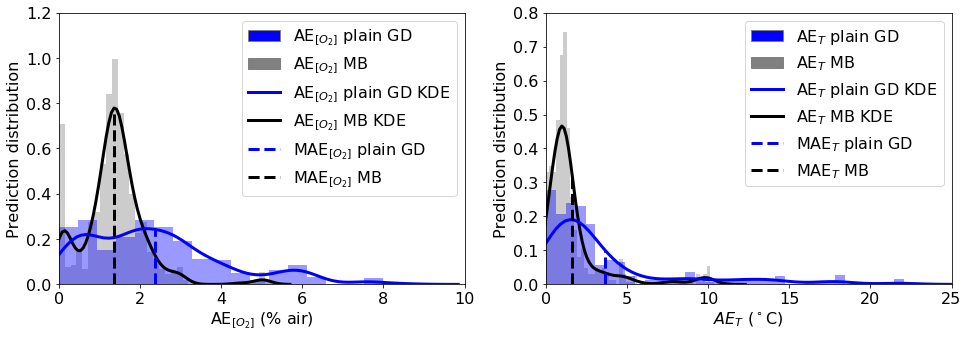

In [92]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAE_boxplot_C_flat2, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})


custom_lines = [Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='black', lw=3),
                Line2D([0], [0], color='blue', lw=3, ls = '--'),
                Line2D([0], [0], color='black', lw=3, ls = '--')
                
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ plain GD','AE$_{[O_2]}$ MB', 
                         'AE$_{[O_2]}$ plain GD KDE','AE$_{[O_2]}$ MB KDE',
                         'MAE$_{[O_2]}$ plain GD','MAE$_{[O_2]}$ MB' ], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Prediction distribution', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 1.2)
plt.xlim(0, 10)

m_ = np.mean(MAE_boxplot_C_flat)
m_2_ = np.mean(MAE_boxplot_C_flat2)

plt.plot([m_, m_], [0, 0.78], lw = 3, ls = '--', color = 'black')
plt.plot([m_2_, m_2_], [0, 0.24], lw = 3, ls = '--', color = 'blue')



ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAET_boxplot_C_MTL_flat2, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)
plt.ylabel('Prediction distribution', fontsize = 16)
plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='black', lw=3),
                Line2D([0], [0], color='blue', lw=3, ls = '--'),
                Line2D([0], [0], color='black', lw=3, ls = '--')
                ]

ax.legend(custom_lines, ['AE$_{T}$ plain GD','AE$_{T}$ MB', 
                         'AE$_{T}$ plain GD KDE','AE$_{T}$ MB KDE',
                         'MAE$_{T}$ plain GD','MAE$_{T}$ MB' ], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 0.8)
plt.xlim(0, 25)

m_ = np.mean(MAET_boxplot_C_MTL_flat)
m_2_ = np.mean(MAET_boxplot_C_MTL_flat2)

plt.plot([m_, m_], [0, 0.32], lw = 3, ls = '--', color = 'black')
plt.plot([m_2_, m_2_], [0, 0.10], lw = 3, ls = '--', color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



fig.savefig('../paper/comparison_theta90_mb_vs_nomb_20k.svg', format='svg', dpi=300,bbox_inches='tight')

# Figure: theta/90, mini-batch, 20k vs 100k - TODO

In [251]:
# eventually load the model again
model = keras.models.load_model("model_20001_32_1e-3_3x50_2x5_2x5.h5")
model2 = keras.models.load_model("model_100001_32_1e-3_3x50_2x5_2x5.h5")

In [252]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions(model)


#targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df2, preds_exp_T_df2 = get_predictions(model2)

In [254]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]


MAE_boxplot_C2, MAE_list_C2, MAE_xticks_C2 = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df2)
MAET_boxplot_C_MTL2, MAET_list_C_MTL2, MAET_xticks_C_MTL2 = MAE_T_list_generator(targets_dev, preds_exp_T_df2)
MAE_boxplot_C_flat2 = [item for sublist in MAE_boxplot_C2 for item in sublist]
MAET_boxplot_C_MTL_flat2 = [item for sublist in MAET_boxplot_C_MTL2 for item in sublist]

In [255]:
print(MAE_list_C)
print(np.mean(MAE_boxplot_C_flat))

print(MAE_list_C2)
print(np.mean(MAE_boxplot_C_flat2))

[0.14425078106774808, 2.2521701353053523, 1.348282308645651, 1.2189798388216246, 1.2084147135416654, 1.2196332216262795, 1.408922578159132, 1.5852960906451283, 1.5059255686673243, 1.8802897377711985]
1.3673768710801737
[0.06314535176448792, 0.1624194808202247, 0.2208781032495092, 0.17740046812428473, 0.2178817907969147, 0.23302482020470303, 0.2274247533396667, 0.27714311322079543, 0.3442054878581645, 0.2875853893233517]
0.21707888660635186


<Figure size 432x288 with 0 Axes>

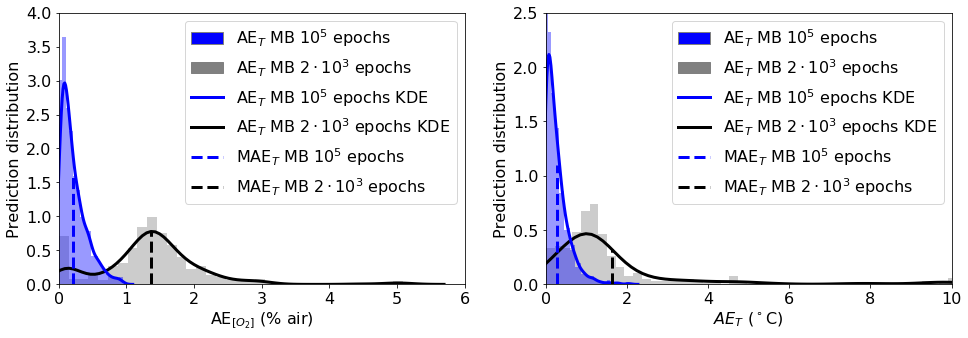

In [256]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAE_boxplot_C_flat2, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})


custom_lines = [Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='black', lw=3),
                Line2D([0], [0], color='blue', lw=3, ls = '--'),
                Line2D([0], [0], color='black', lw=3, ls = '--')
                
                ]

ax.legend(custom_lines, ['AE$_{T}$ MB $10^5$ epochs','AE$_{T}$ MB $2\cdot 10^3$ epochs', 
                         'AE$_{T}$ MB $10^5$ epochs KDE','AE$_{T}$ MB $2\cdot 10^3$ epochs KDE',
                         'MAE$_{T}$ MB $10^5$ epochs','MAE$_{T}$ MB $2\cdot 10^3$ epochs' ], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Prediction distribution', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 4)
plt.xlim(0, 6)

m_ = np.mean(MAE_boxplot_C_flat)
m_2_ = np.mean(MAE_boxplot_C_flat2)

plt.plot([m_, m_], [0, 0.78], lw = 3, ls = '--', color = 'black')
plt.plot([m_2_, m_2_], [0, 1.63], lw = 3, ls = '--', color = 'blue')



ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAET_boxplot_C_MTL_flat2, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)
plt.ylabel('Prediction distribution', fontsize = 16)
plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='black', lw=3),
                Line2D([0], [0], color='blue', lw=3, ls = '--'),
                Line2D([0], [0], color='black', lw=3, ls = '--')
                ]

ax.legend(custom_lines, ['AE$_{T}$ MB $10^5$ epochs','AE$_{T}$ MB $2\cdot 10^3$ epochs', 
                         'AE$_{T}$ MB $10^5$ epochs KDE','AE$_{T}$ MB $2\cdot 10^3$ epochs KDE',
                         'MAE$_{T}$ MB $10^5$ epochs','MAE$_{T}$ MB $2\cdot 10^3$ epochs' ], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 2.5)
plt.xlim(0, 10)

m_ = np.mean(MAET_boxplot_C_MTL_flat)
m_2_ = np.mean(MAET_boxplot_C_MTL_flat2)

plt.plot([m_, m_], [0, 0.33], lw = 3, ls = '--', color = 'black')
plt.plot([m_2_, m_2_], [0, 1.1], lw = 3, ls = '--', color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('../paper/comparison_theta90_20k_vs_100k.svg', format='svg', dpi=300,bbox_inches='tight')

# Figure: theta/theta0 mini-batch 20k - Dataset 2

In [263]:
# eventually load the model again
model = keras.models.load_model("model_20000_32_1e-3_3x50_2x5_2x5_theta_theta0.h5")

In [264]:
targets_dev2 = targets_dev2.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions2(model)

In [265]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev2, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev2, preds_exp_T_df)
MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [266]:
print(MAE_list_C)
print(np.mean(MAE_boxplot_C_flat))

[0.008751188870519122, 0.03378090185996845, 0.09707276026407849, 0.1440055817365662, 0.18107341997551066, 0.16374097482578007, 0.1544598357318199, 0.13075642152266118, 0.163340111301369, 0.1770107846864516]
0.1310816762674505


<Figure size 432x288 with 0 Axes>

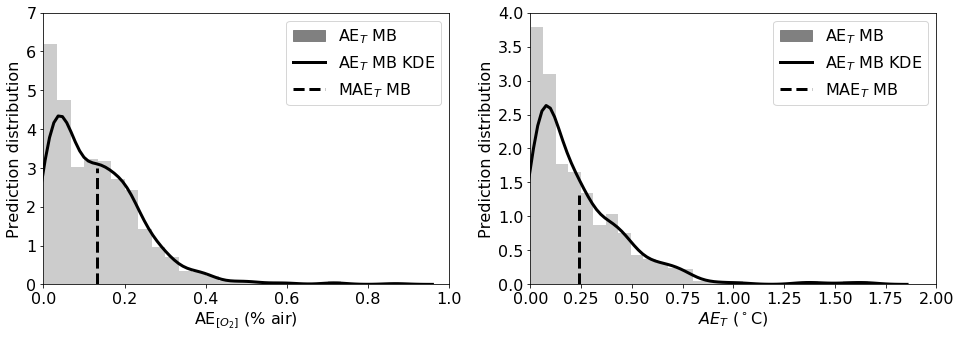

In [267]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})




custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Line2D([0], [0], color='black', lw=3),
                Line2D([0], [0], color='black', lw=3, ls = '--')
                ]

ax.legend(custom_lines, ['AE$_{T}$ MB', 
                         'AE$_{T}$ MB KDE',
                         'MAE$_{T}$ MB' ], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Prediction distribution', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 7)
plt.xlim(0, 1.0)

m_ = np.mean(MAE_boxplot_C_flat)

plt.plot([m_, m_], [0, 3], lw = 3, ls = '--', color = 'black')



ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})


    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)
plt.ylabel('Prediction distribution', fontsize = 16)
plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [
                Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Line2D([0], [0], color='black', lw=3),
                Line2D([0], [0], color='black', lw=3, ls = '--')
                ]

ax.legend(custom_lines, ['AE$_{T}$ MB', 
                         'AE$_{T}$ MB KDE',
                         'MAE$_{T}$ MB' ], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 4)
plt.xlim(0, 2)

m_ = np.mean(MAET_boxplot_C_MTL_flat)

plt.plot([m_, m_], [0, 1.32], lw = 3, ls = '--', color = 'black')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



fig.savefig('../paper/theta_theta0_mb_20k.svg', format='svg', dpi=300,bbox_inches='tight')

# ELT plot - theta/theta0 20k MB

100% ->  0.87
80% ->  2.19


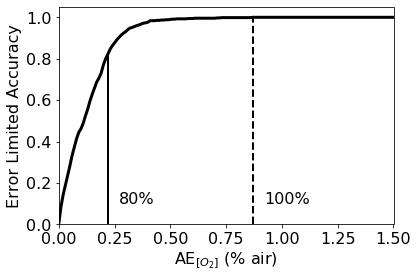

In [343]:
ax = []
xarray = np.arange(0, 5, 0.01)
for x_ in xarray:
    ax.append(np.sum(np.array(MAE_boxplot_C_flat) < x_)/len(MAE_boxplot_C_flat))
    
minidx = np.min(np.where(np.array(ax) == 1.0))
minidx2 = np.min(np.where(np.array(ax) > 0.8))


fig = plt.figure()
plt.plot(np.arange(0, 5, 0.01), ax, lw = 3, color = 'black')
plt.tick_params(labelsize=16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.ylabel('Error Limited Accuracy', fontsize = 16)
plt.xlim(0,1.5)
plt.ylim(0, None)

#plt.plot([1.1957, 1.1957], [0, 0.25], lw = 2, color = 'black')
#plt.text(0.3,0.3,'25%', fontsize = 16)

plt.plot([xarray[minidx2], xarray[minidx2]], [0, ax[minidx2]], lw = 2, color = 'black')
#plt.plot([0, 2.19], [0.8, 0.8], lw = 2, color = 'black')
plt.text(xarray[minidx2]+0.05,0.1,'80%', fontsize = 16)


plt.plot([xarray[minidx], xarray[minidx]], [0, 1.0], lw = 2, color = 'black', ls = '--')

plt.text(xarray[minidx]+0.05,0.1,'100%', fontsize = 16, color = 'black')
print('100% -> ', xarray[minidx])
print('80% -> ', 2.19)

plt.show()

fig.savefig('../paper/ELA_model_20001_32_1e-3_3x50_2x5_2x5_theta_theta0.svg', format='svg', dpi=300,bbox_inches='tight')
fig.savefig('../paper/ELA_model_20001_32_1e-3_3x50_2x5_2x5_theta_theta0.eps', format='eps', dpi=300,bbox_inches='tight')

# ELA plot - theta/90 100k

100% ->  0.9500000000000001
80% ->  2.19


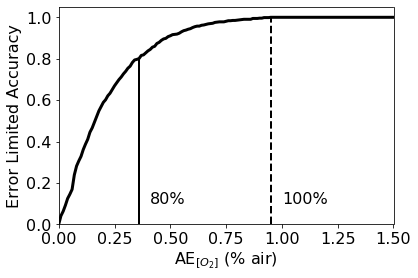

In [342]:
ax = []
xarray = np.arange(0, 5, 0.01)
for x_ in xarray:
    ax.append(np.sum(np.array(MAE_boxplot_C_flat2) < x_)/len(MAE_boxplot_C_flat2))
    
minidx = np.min(np.where(np.array(ax) == 1.0))
minidx2 = np.min(np.where(np.array(ax) > 0.8))


fig = plt.figure()
plt.plot(np.arange(0, 5, 0.01), ax, lw = 3, color = 'black')
plt.tick_params(labelsize=16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.ylabel('Error Limited Accuracy', fontsize = 16)
plt.xlim(0,1.5)
plt.ylim(0, None)

#plt.plot([1.1957, 1.1957], [0, 0.25], lw = 2, color = 'black')
#plt.text(0.3,0.3,'25%', fontsize = 16)

plt.plot([xarray[minidx2], xarray[minidx2]], [0, ax[minidx2]], lw = 2, color = 'black')
#plt.plot([0, 2.19], [0.8, 0.8], lw = 2, color = 'black')
plt.text(xarray[minidx2]+0.05,0.1,'80%', fontsize = 16)


plt.plot([xarray[minidx], xarray[minidx]], [0, 1.0], lw = 2, color = 'black', ls = '--')

plt.text(xarray[minidx]+0.05,0.1,'100%', fontsize = 16, color = 'black')
print('100% -> ', xarray[minidx])
print('80% -> ', 2.19)

plt.show()

fig.savefig('../paper/ELA_model_100001_32_1e-3_3x50_2x5_2x5_theta90.svg', format='svg', dpi=300,bbox_inches='tight')
fig.savefig('../paper/ELA_model_100001_32_1e-3_3x50_2x5_2x5_theta90.eps', format='eps', dpi=300,bbox_inches='tight')

# ELA Plot comparison theta/90, MB 100k vs theta/theta0, MB, 20k

100% ->  0.87
100% ->  0.9500000000000001
80% ->  2.19


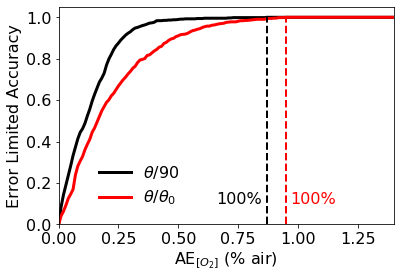

In [331]:
ax = []
xarray = np.arange(0, 5, 0.01)
for x_ in xarray:
    ax.append(np.sum(np.array(MAE_boxplot_C_flat) < x_)/len(MAE_boxplot_C_flat))
    
minidx = np.min(np.where(np.array(ax) == 1.0))
minidx2 = np.min(np.where(np.array(ax) > 0.8))

ax2 = []
xarray2 = np.arange(0, 5, 0.01)
for x_ in xarray2:
    ax2.append(np.sum(np.array(MAE_boxplot_C_flat2) < x_)/len(MAE_boxplot_C_flat2))

minidx_2 = np.min(np.where(np.array(ax2) == 1.0))
minidx2_2 = np.min(np.where(np.array(ax2) > 0.8))


fig = plt.figure()
plt.plot(np.arange(0, 5, 0.01), ax, lw = 3, color = 'black', label = r'$\theta/90$')
plt.plot(np.arange(0, 5, 0.01), ax2, lw = 3, color = 'red', label = r'$\theta/\theta_0$')
plt.tick_params(labelsize=16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.ylabel('Error Limited Accuracy', fontsize = 16)
plt.xlim(0,1.4)
plt.ylim(0, None)


#plt.plot([xarray[minidx2], xarray[minidx2]], [0, 0.73], lw = 2, color = 'black')
#plt.text(xarray[minidx2]+0.05,0.1,'80%', fontsize = 16)
plt.plot([xarray[minidx], xarray[minidx]], [0, 1.0], lw = 2, color = 'black', ls = '--')
plt.text(xarray[minidx]-0.21,0.1,'100%', fontsize = 16, color = 'black')

#plt.plot([xarray2[minidx2_2], xarray2[minidx2_2]], [0, 0.73], lw = 2, color = 'black')
#plt.text(xarray2[minidx2_2]+0.05,0.1,'80%', fontsize = 16)
plt.plot([xarray2[minidx_2], xarray2[minidx_2]], [0, 1.0], lw = 2, color = 'red', ls = '--')
plt.text(xarray2[minidx_2]+0.02,0.1,'100%', fontsize = 16, color = 'red')



print('100% -> ', xarray[minidx])
print('100% -> ', xarray2[minidx_2])
print('80% -> ', 2.19)
plt.legend(fontsize = 16,  frameon=False,
          loc = (0.1, 0.05))

plt.show()

fig.savefig('../paper/ELA_comparison.svg', format='svg', dpi=300,bbox_inches='tight')

# Results from the model

In [163]:
# Eventually load the model again
model = keras.models.load_model("model_100001_32_1e-3_3x50_2x5_2x5.h5")

In [164]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions(model)

In [165]:
MAE_boxplot_C_3, MAE_list_C_3, MAE_xticks_C_3 = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL_3, MAET_list_C_MTL_3, MAET_xticks_C_MTL_3 = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAE_boxplot_C_flat_3 = [item for sublist in MAE_boxplot_C_3 for item in sublist]
MAET_boxplot_C_MTL_flat_3 = [item for sublist in MAET_boxplot_C_MTL_3 for item in sublist]

In [166]:
print(MAE_list_C_3)
print(np.mean(MAE_boxplot_C_flat_3))
print(np.mean(MAET_boxplot_C_MTL_flat_3))

[0.06314535176448792, 0.1624194808202247, 0.2208781032495092, 0.17740046812428473, 0.2178817907969147, 0.23302482020470303, 0.2274247533396667, 0.27714311322079543, 0.3442054878581645, 0.2875853893233517]
0.21707888660635186
0.2678020759707401


<Figure size 432x288 with 0 Axes>

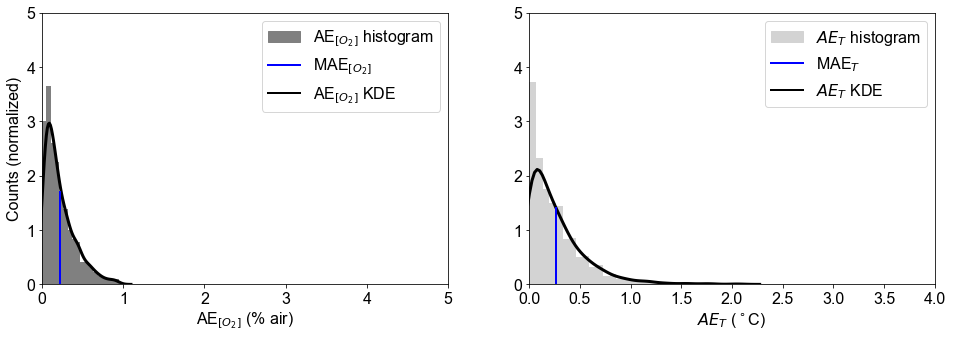

In [186]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ histogram', 'MAE$_{[O_2]}$', 'AE$_{[O_2]}$ KDE'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 5)
plt.xlim(0, 5)

m_ = np.mean(MAE_boxplot_C_flat_3)

plt.plot([m_, m_], [0, 1.7], lw = 2, color = 'blue')


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat_3,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "lightgray"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='lightgray', edgecolor='lightgray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['$AE_T$ histogram', 'MAE$_T$', '$AE_T$ KDE'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 5.0)
plt.xlim(0, 4)

m_ = np.mean(MAET_boxplot_C_MTL_flat_3)

plt.plot([m_, m_], [0, 1.4], lw = 2, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.eps', format='eps', dpi=300,bbox_inches='tight')

# Comparison between the two networks

<Figure size 432x288 with 0 Axes>

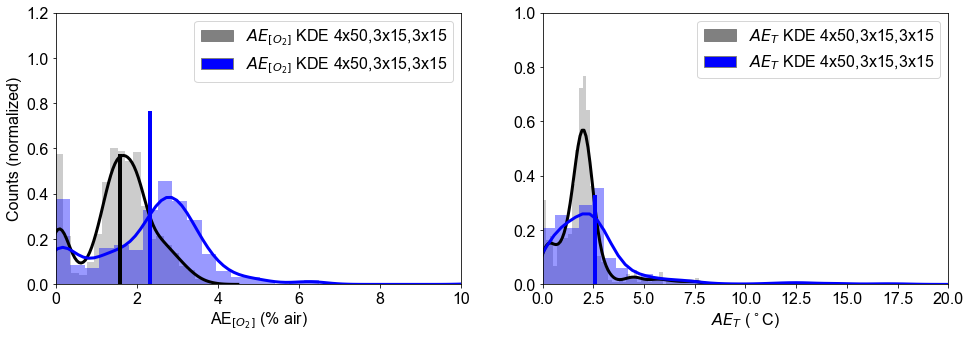

W0220 22:02:12.834388 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.835355 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.836024 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.836899 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.837621 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.838819 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.839668 4724334016 b

In [135]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAE_boxplot_C_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['$AE_{[O_2]}$ KDE 4x50,3x15,3x15', '$AE_{[O_2]}$ KDE 4x50,3x15,3x15'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 1.2)
plt.xlim(0, 10)

m_ = np.mean(MAE_boxplot_C_flat)
m_3_ = np.mean(MAE_boxplot_C_flat_3)

plt.plot([m_, m_], [0, 0.565], lw = 4, color = 'black')
plt.plot([m_3_, m_3_], [0, 0.755], lw = 4, color = 'blue')



ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAET_boxplot_C_MTL_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['$AE_T$ KDE 4x50,3x15,3x15', '$AE_T$ KDE 4x50,3x15,3x15'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 1.0)
plt.xlim(0, 20)

m_ = np.mean(MAET_boxplot_C_MTL_flat_3)

plt.plot([m_, m_], [0, 0.32], lw = 4, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.eps', format='eps', dpi=300,bbox_inches='tight')